# Installing and Importing Libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Media Keypoints

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results): 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

## Setting up folders

In [3]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Test Data') 
# Actions that we try to detect
actions = np.array(["Hello","Good","Superb","Stable","Bad","A","B","C","D"])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

# Data Preprocessing, Creating Labels and Features

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label:num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


# Build, Train LSTM Neural Network

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [7]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=250, callbacks=[tb_callback])

Epoch 1/250
8/8 [==============================] - 5s 51ms/step - loss: 2.1908 - categorical_accuracy: 0.1193
Epoch 2/250
8/8 [==============================] - 0s 52ms/step - loss: 2.1905 - categorical_accuracy: 0.1852
Epoch 3/250
8/8 [==============================] - 0s 52ms/step - loss: 2.1299 - categorical_accuracy: 0.3333
Epoch 4/250
8/8 [==============================] - 0s 53ms/step - loss: 2.1470 - categorical_accuracy: 0.3663
Epoch 5/250
8/8 [==============================] - 0s 55ms/step - loss: 2.0965 - categorical_accuracy: 0.3539
Epoch 6/250
8/8 [==============================] - 0s 54ms/step - loss: 1.9273 - categorical_accuracy: 0.3663
Epoch 7/250
8/8 [==============================] - 1s 61ms/step - loss: 1.7968 - categorical_accuracy: 0.3745
Epoch 8/250
8/8 [==============================] - 1s 57ms/step - loss: 1.8730 - categorical_accuracy: 0.3498
Epoch 9/250
8/8 [==============================] - 0s 55ms/step - loss: 1.7741 - categorical_accuracy: 0.4074
Epoch 10/2

8/8 [==============================] - 1s 60ms/step - loss: 0.4699 - categorical_accuracy: 0.8519
Epoch 148/250
8/8 [==============================] - 0s 54ms/step - loss: 0.2832 - categorical_accuracy: 0.9095
Epoch 149/250
8/8 [==============================] - 0s 50ms/step - loss: 0.2042 - categorical_accuracy: 0.9383
Epoch 150/250
8/8 [==============================] - 0s 51ms/step - loss: 0.1517 - categorical_accuracy: 0.9588
Epoch 151/250
8/8 [==============================] - 0s 55ms/step - loss: 0.1088 - categorical_accuracy: 0.9712
Epoch 152/250
8/8 [==============================] - 0s 55ms/step - loss: 0.1004 - categorical_accuracy: 0.9630
Epoch 153/250
8/8 [==============================] - 0s 52ms/step - loss: 0.1082 - categorical_accuracy: 0.9712
Epoch 154/250
8/8 [==============================] - 0s 57ms/step - loss: 0.0768 - categorical_accuracy: 0.9794
Epoch 155/250
8/8 [==============================] - 0s 51ms/step - loss: 0.0765 - categorical_accuracy: 0.9753
Epoch 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 9)                 297       
                                                                 
Total params: 203,657
Trainable params: 203,657
Non-trai

# Make Prediction

In [9]:
res = model.predict(X_test)

1/1 [==============================] - 1s 560ms/step


In [10]:
res

array([[7.62816546e-12, 3.76905203e-01, 4.93509220e-15, 6.70243483e-14,
        4.16143869e-10, 4.69467267e-02, 1.52300895e-14, 1.11958492e-07,
        5.76147914e-01],
       [1.95433226e-04, 7.16221926e-04, 4.02207014e-08, 9.43508089e-01,
        2.59327926e-02, 2.86155045e-02, 5.06885233e-04, 2.12023333e-05,
        5.03638003e-04],
       [5.77232822e-05, 2.91762114e-10, 1.74647108e-01, 1.09624219e-11,
        7.45240832e-03, 1.71159616e-06, 3.24258298e-01, 4.93582815e-01,
        2.30231478e-08],
       [1.74054456e-12, 6.25699473e-25, 8.32457943e-07, 1.20805252e-23,
        4.83900753e-10, 4.42463773e-17, 9.99999166e-01, 3.48849372e-09,
        1.04254765e-22],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.13473278e-16, 0.00000000e+00, 0.00000000e+00,
        5.25225137e-23],
       [3.49894016e-08, 1.16625487e-10, 5.02814402e-19, 4.57696680e-29,
        9.15069916e-16, 7.28799563e-08, 1.23138749e-18, 1.96082897e-06,
        9.9

In [11]:
actions[np.argmax(res[3])]

'B'

In [12]:
actions[np.argmax(y_test[3])]

'B'

# Save Weights

In [13]:
model.save('model_27_04.h5')

In [5]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('model_27_04.h5')

# Evaluation

In [6]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [7]:
yhat = model.predict(X_test)

1/1 [==============================] - 4s 4s/step


In [8]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [9]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[23,  0],
        [ 0,  4]],

       [[22,  0],
        [ 0,  5]],

       [[25,  0],
        [ 0,  2]],

       [[21,  0],
        [ 0,  6]],

       [[24,  0],
        [ 0,  3]],

       [[23,  0],
        [ 0,  4]],

       [[25,  0],
        [ 0,  2]],

       [[26,  0],
        [ 0,  1]]], dtype=int64)

In [10]:
accuracy_score(ytrue, yhat)

1.0

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

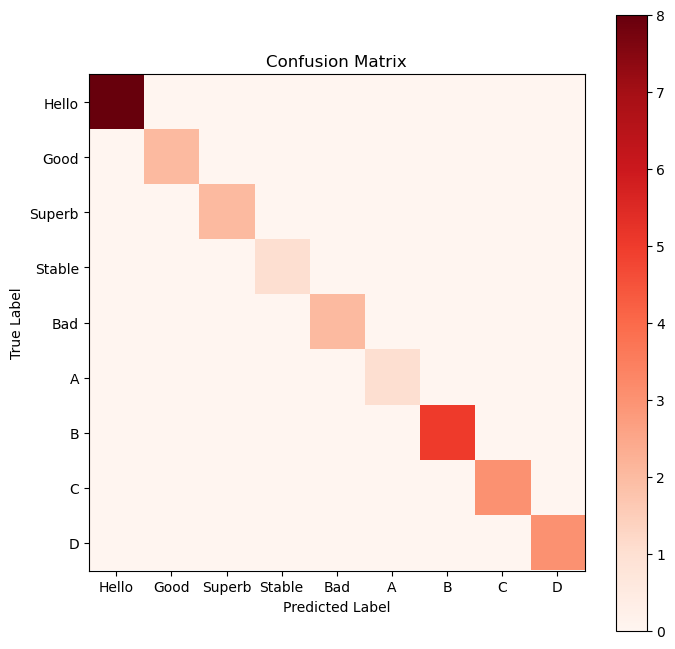

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(ytrue, yhat)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
ax.figure.colorbar(im, ax=ax)
ax.set(title='Confusion Matrix', xlabel='Predicted Label', ylabel='True Label')
ax.set_xticks(np.arange(len(label_map)))
ax.set_yticks(np.arange(len(label_map)))
ax.set_xticklabels(label_map)
ax.set_yticklabels(label_map)
plt.show()

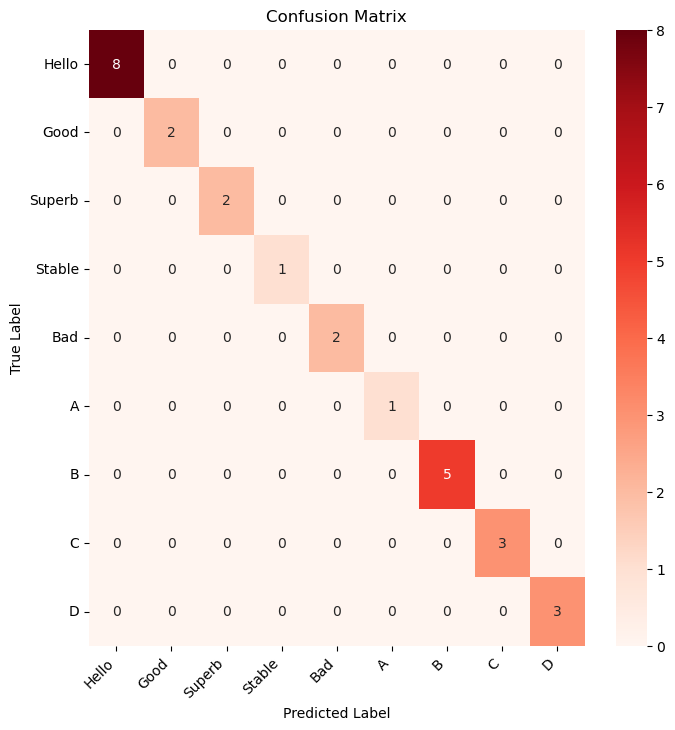

In [16]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(ytrue, yhat)
sns.heatmap(cm, annot=True, cmap=plt.cm.Reds, ax=ax, fmt='g')
ax.set(title='Confusion Matrix', xlabel='Predicted Label', ylabel='True Label')
ax.set_xticklabels(label_map, rotation=45, ha='right')
ax.set_yticklabels(label_map, rotation=0)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix

# Get predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to predicted labels
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to labels
y_true = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))

# Generate confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


1/1 [==============================] - 0s 53ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Confusion Matrix:
[[[23  0]
  [ 0  4]]

 [[22  0]
  [ 0  5]]

 [[25  0]
  [ 0  2]]

 [[21  0]
  [ 0  6]]

 [[24  0]
  [ 0  3]]

 [[23  0]
  [ 0  4]]

 [[25  0]
  [ 0  2]]

 [[26  0]
  [ 0  1]]]


Epoch 1/250
7/7 [==============================] - 8s 983ms/step - loss: 0.0711 - categorical_accuracy: 0.9817 - val_loss: 0.0128 - val_categorical_accuracy: 1.0000
Epoch 2/250
7/7 [==============================] - 4s 606ms/step - loss: 0.2757 - categorical_accuracy: 0.9266 - val_loss: 0.2642 - val_categorical_accuracy: 0.9600
Epoch 3/250
7/7 [==============================] - 4s 555ms/step - loss: 0.4134 - categorical_accuracy: 0.8807 - val_loss: 0.0353 - val_categorical_accuracy: 1.0000
Epoch 4/250
7/7 [==============================] - 4s 565ms/step - loss: 0.1515 - categorical_accuracy: 0.9587 - val_loss: 0.0394 - val_categorical_accuracy: 1.0000
Epoch 5/250
7/7 [==============================] - 4s 591ms/step - loss: 0.1220 - categorical_accuracy: 0.9633 - val_loss: 0.0483 - val_categorical_accuracy: 1.0000
Epoch 6/250
7/7 [==============================] - 4s 614ms/step - loss: 0.1132 - categorical_accuracy: 0.9633 - val_loss: 0.0392 - val_categorical_accuracy: 1.0000
Epoch 7/25

7/7 [==============================] - 4s 617ms/step - loss: 0.0440 - categorical_accuracy: 0.9908 - val_loss: 0.0070 - val_categorical_accuracy: 1.0000
Epoch 100/250
7/7 [==============================] - 4s 598ms/step - loss: 0.0474 - categorical_accuracy: 0.9862 - val_loss: 0.0112 - val_categorical_accuracy: 1.0000
Epoch 101/250
7/7 [==============================] - 4s 577ms/step - loss: 0.0418 - categorical_accuracy: 0.9908 - val_loss: 0.0114 - val_categorical_accuracy: 1.0000
Epoch 102/250
7/7 [==============================] - 4s 603ms/step - loss: 0.0444 - categorical_accuracy: 0.9908 - val_loss: 0.0086 - val_categorical_accuracy: 1.0000
Epoch 103/250
7/7 [==============================] - 4s 647ms/step - loss: 0.0433 - categorical_accuracy: 0.9908 - val_loss: 0.0116 - val_categorical_accuracy: 1.0000
Epoch 104/250
7/7 [==============================] - 4s 564ms/step - loss: 0.0411 - categorical_accuracy: 0.9908 - val_loss: 0.0124 - val_categorical_accuracy: 1.0000
Epoch 105/25

7/7 [==============================] - 4s 623ms/step - loss: 0.0397 - categorical_accuracy: 0.9908 - val_loss: 0.0103 - val_categorical_accuracy: 1.0000
Epoch 198/250
7/7 [==============================] - 5s 710ms/step - loss: 0.0395 - categorical_accuracy: 0.9908 - val_loss: 0.0106 - val_categorical_accuracy: 1.0000
Epoch 199/250
7/7 [==============================] - 4s 604ms/step - loss: 0.0396 - categorical_accuracy: 0.9908 - val_loss: 0.0095 - val_categorical_accuracy: 1.0000
Epoch 200/250
7/7 [==============================] - 4s 577ms/step - loss: 0.0394 - categorical_accuracy: 0.9908 - val_loss: 0.0092 - val_categorical_accuracy: 1.0000
Epoch 201/250
7/7 [==============================] - 4s 601ms/step - loss: 0.0397 - categorical_accuracy: 0.9908 - val_loss: 0.0109 - val_categorical_accuracy: 1.0000
Epoch 202/250
7/7 [==============================] - 4s 599ms/step - loss: 0.0399 - categorical_accuracy: 0.9908 - val_loss: 0.0115 - val_categorical_accuracy: 1.0000
Epoch 203/25

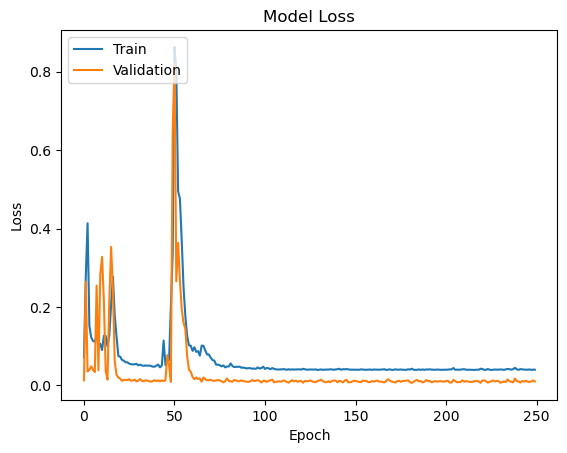

In [30]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=250, validation_split=0.1, callbacks=[tb_callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

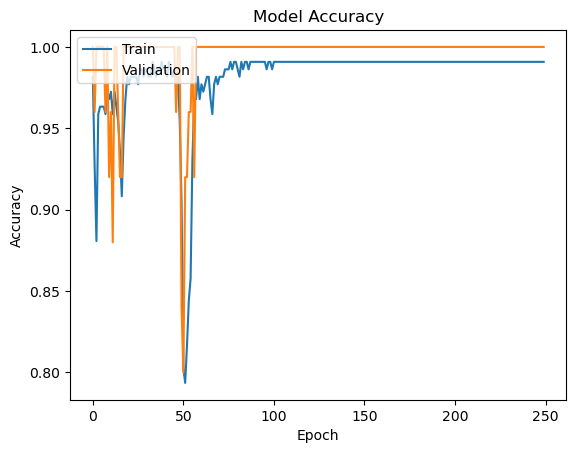

In [32]:
#Plot of training and validation accuracy vs. epoch
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


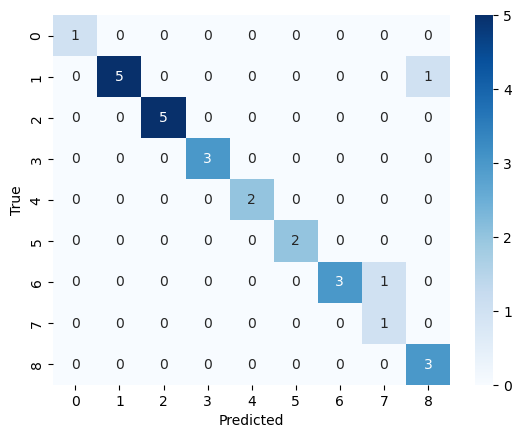

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(ytrue, yhat)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# RealTime Testing

In [12]:
def startRecognizer():
    # 1. New detection variables
    sequence = []
    predicted_Word = "Predictions"
    predictions = []
    threshold = 0.8
    
    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.8) as holistic:
        while cap.isOpened():
            # Read feed
            ret, frame = cap.read()
    
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            print(results)
            
            # Draw landmarks
            draw_styled_landmarks(image, results)
            
            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                
            #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        predicted_Word = str(actions[np.argmax(res)])
                        if (predicted_Word == "Stable"):
                            predicted_Word = ""
            
            #Print text on video
            cv2.putText(image, predicted_Word, (250,50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            
            # Show to screen
            cv2.imshow('Live Feed', image)
    
            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

In [15]:
# import everything from tkinter module
from tkinter import *   
 
# create a tkinter window
root = Tk()             
root.attributes('-fullscreen', True)
label = Label(root, text ="Sign Language Recognizer",font=("Arial", 25)).pack()
label = Label(root, text ='Press "q" to turn off video.',font=("Arial", 10)).pack()
 
# Create a Button
btn2 = Button(root, text = 'Start Recognizer', bd = '5',
                          command = startRecognizer,font=("Arial", 20))
btn1 = Button(root, text = 'Exit', bd = '5',
                          command = root.destroy,font=("Arial", 20))
 
# Set the position of button at the buttom of window.  
btn1.pack(side = 'bottom')
btn2.pack(side = 'bottom')
 
root.mainloop()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 37ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1

C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29m

Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===

1/1 [==============================] - 0s 31ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 46ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 49ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Stable
<class 'media

1/1 [==============================] - 0s 20ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'media

1/1 [==============================] - 0s 33ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 39ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 46ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Stable
<class 'media

1/1 [==============================] - 0s 30ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 39ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 39ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 45ms/step
Stable
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Stable
<class 'media

1/1 [==============================] - 0s 44ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
D
<class 'mediapipe.python.solution_base

1/1 [==============================] - 0s 33ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 58ms/step
C
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
C
<class 'mediapipe.python.solution_base

1/1 [==============================] - 0s 32ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 48ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Bad
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Bad
<class 'mediapipe.python.solution_base.S

1/1 [==============================] - 0s 39ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 39ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 46ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs

1/1 [==============================] - 0s 27ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 45ms/step
Hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
D
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
D
<class 'mediapipe.python.solution_base

1/1 [==============================] - 0s 41ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Superb
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
Superb
<class 'media